In [1]:
import numpy as np
from pyletkf import pyletkf

## Congiguration  
To configurate the pyletkf, first we need to create config file in python configparser format!  
Simply, you only need to declare variables ```a = "this is a"``` in any data type. 
Sample file is included in this repo., and these are the variables you need to declare.  

In [2]:
!cat ./pyletkf/config.ini

# initial configuration for LETKF-python-API  
[assimilation]

nCpus        = 12
# number of CPUs

ensMem       = 20
# number of ensemble members

patchArea    = 120000
# patch area size

localPatchPath = ./localPatch.hdf5
# path to the cached local patch file.

[model]

nReach       = 28998
# number of reaches or total grid cells

networkFile = ./network.csv
# river network file if applicable

networktype = "csv"
# river network file type ("csv", "nextxy") if applicable
# "csv": network table format
# "nextxy": next grid cell number format

[observation]

undef        = -9999
# undefined value

Most of the variables are self-descriptive, but:
- nReach: number of total points in your data in 1D vectorized format.  
- networkFile, networtype: for hydrological application, pyletkf natively supports dynamic generation of local patches based on your river network. See README for further description. Ignore this if not applicable.  
- patchArea: threshold value to construct local patch if you use above network-based local patch generation. Ignore this if not applicable.  
- undef: undefined value in your observation data.  

Specify your config file when you instanciate pyletkf.LETKF_core class.  
If use_cache=False, the instance will try to create network-based local-patches based on the information configured.  
If you do not want to use those, plese make your own local patch object; list of list containing vector (your vectorized data) indices which should be in each patch. (e.g., ```[[0,1,2], [1,3,5], [2,4,6], [3,10,15], ...]```) Save it as hdf5 format (vlen_int) and specify path in configration file.  

In [3]:
dacore = pyletkf.LETKF_core("./pyletkf/config.ini", mode="vector", use_cache=True)

Read variables from configuration...
############Check instance variables############
mode:vector
reach_start:1
use_cache:True
localPatchPath:./localPatch.hdf5
ensMem:20
patchArea:120000.0
networkFile:./network.csv
nReach:28998
networktype:"csv"
undef:-9999.0
reaches:[    0     1     2 ... 28995 28996 28997]
##############


change instance variables if you have anything to tweak.  
call ${instance}.initialize() to read pre-cached local patches or generate them.  
initialize() also checks 1. whether all required variables are declared 2. data consistency, and throws IOError if not good.  

In [4]:
dacore.initialize()

## Toy models  

Now, let's create toy models to see how to assimilate variables.  
In the configuration above, we have 28998 model points, and pre-cached local patch is loaded already.  
Let's see how do local patches look like.  

In [5]:
dacore.patches[0:10]

[[0, 5, 9],
 [1, 5, 9],
 [2, 7, 11],
 [3, 7, 11],
 [4, 9, 15],
 [5, 1, 0, 9, 15],
 [6, 11, 16],
 [7, 3, 2, 11, 16],
 [8, 15, 20],
 [9, 5, 4, 15, 1, 0, 20]]

Again, these are the indices of your data vector (in this case, vector having shape ```[28998,]```).  
  
Let's define a forwarding model we use here:  

In [6]:
def forward(x, a, b):
    return a*x + b

Here, x is a time-dependent variable, and a and b are model parameters.  
Lets's define ground truth:  

In [7]:
nT = 10
xt1 = np.random.uniform(0,1,dacore.nReach)  # initial state
at = 2
bt = 1

xti = xt1
t = 0
out = []
while t<nT:
    xti = forward(xti, at, bt)
    out.append(xti)
    t += 1
xt = np.vstack(out)
xt

array([[1.05412072e+01, 1.15504373e+01, 1.01353851e+01, ...,
        1.19227389e+01, 1.02769453e+01, 1.10598743e+01],
       [4.16236217e+01, 4.46513119e+01, 4.04061552e+01, ...,
        4.57682166e+01, 4.08308359e+01, 4.31796229e+01],
       [1.34870865e+02, 1.43953936e+02, 1.31218466e+02, ...,
        1.47304650e+02, 1.32492508e+02, 1.39538869e+02],
       ...,
       [3.39836203e+04, 3.61908064e+04, 3.30960872e+04, ...,
        3.70050299e+04, 3.34056793e+04, 3.51179451e+04],
       [1.01960861e+05, 1.08582419e+05, 9.92982615e+04, ...,
        1.11025090e+05, 1.00227038e+05, 1.05363835e+05],
       [3.05892582e+05, 3.25757258e+05, 2.97904784e+05, ...,
        3.33085269e+05, 3.00691114e+05, 3.16101506e+05]])

Text(0.5,1,'Ground Truth at index [28998]')

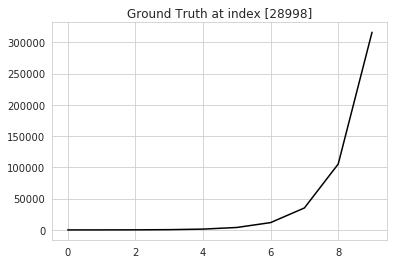

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.lineplot(range(10), xt[:, -1], color="k");plt.title("Ground Truth at index [{0}]".format(dacore.nReach))

Now, let's make ensembles with perturbated initial conditions:  

In [9]:
eTot = dacore.ensMem
a_init = np.random.lognormal(at, 2, eTot)
b_init = np.random.lognormal(bt, 3, eTot)
# expand it to all reaches
a_init = np.array([a_init for r in range(dacore.nReach)]).T
b_init = np.array([b_init for t in range(dacore.nReach)]).T
x_seeds = np.random.uniform(0, 1, size=(eTot, dacore.nReach))
x_init = forward(x_seeds, a_init, b_init)

Above, note that we expand a_init and b_init to all reaches, because most model parameters are space-dependent.  
Even though our forward model has static parameter for all points, this API rather considers as "constant value is distributed for all points", to make vector shape same and algorithm efficient.  

Finally, make observation from ground truth, here just adding some noises on it.  
For the simplicity we assume simple noise from Gaussian distribution.  

In [10]:
std = 10
noises = np.random.normal(0, std, size=xt.shape)
noises_p = noises
obs = xt + noises_p
obserrs = np.ones_like(obs)*std

Text(0.5,1,'Ground Truth/observation at index [28998]')

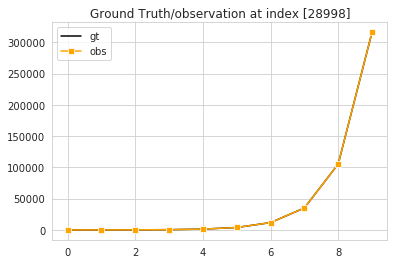

In [11]:
sns.lineplot(range(10), xt[:, -1], label="gt", color="k")
sns.lineplot(range(10), obs[:, -1], label="obs", color="orange", marker="s");plt.title("Ground Truth/observation at index [{0}]".format(dacore.nReach))

Almost Ready! Before dive into assimilation, we need one more step.  
For the API requirement, the state vector (matrix here though; will be converted to a vector in API later by data augumentation) is shaped ```[nvars, eTot, nT, nReach]```. Here:
- nvars: number of variables in a state vector
- eTot: total ensemble number
- nT: time step passed
- nReach: number of points  
Let's make state matrix here:

In [12]:
a_init = a_init.reshape(1, eTot, 1, dacore.nReach)
b_init = b_init.reshape(1, eTot, 1, dacore.nReach)
x_init = x_init.reshape(1, eTot, 1, dacore.nReach)
state_init = np.vstack([x_init, a_init, b_init])
state_init.shape

(3, 20, 1, 28998)

Also, the in case we have observations for multiple variables, the API assumes the shape of the observation/observation-error array in ```[nobsvar, nReach]```, where nobsvar is number of variables available in observaiton.  
Here, we only have observation for x, so just reshape it into ```[1, nT, nReach]```, and we will pass to the API like obs```[:, t, ;]``` to make it the shape above:  

In [13]:
obs = obs.reshape(1, nT, dacore.nReach)
obserrs = obserrs.reshape(1, nT, dacore.nReach)

Also, let's declare forward function for ensembles just to make code simple:

In [14]:
def forward_ens(states_t, eTot, nReach):
    """
    forward model and concatenate it to input.
    Args:
        states (ndarray): state matrix at time t [nvar,eTot,t,nReach]
    Returns:
        ndarray: [nvar,eTot,t+1,nReach]
    """
    x_tp1 = forward(states_t[0, :, -1, :], states_t[1, :, -1, :], states_t[2, :, -1, :])
    states_tp1 = np.vstack([x_tp1, states_t[1, :, -1, :], states_t[2, :, -1, :]]).reshape(3, eTot, 1, nReach)
    return np.concatenate([states_t, states_tp1], axis=2)

Ready! Let's forward one step and execute assimilation.

In [15]:
states = forward_ens(state_init, eTot, dacore.nReach)
obs_now = obs[:, 1, :]
obserr_now = obserrs[:, 1, :]
obsvars = [1, 0, 0]  # explained later
nCPUs = 4
xa, _ = dacore.letkf_vector(states, obs_now, obserr_now, obsvars, nCPUs)

Here, obsvars is a flag to show which layer of state vector is corresponding to observation vector; 1: yes, 0:no.  
In this case, because we only have observation for x, so obsvars will be ```[1, 0, 0]```.
In current version, only direct observation (linear operation H is just identity mapping for those observation is available), to keep the function clean. Getting more complex H can be implemented via directly editing pyletkf/cysrc/letkf.pyx.

When the assimilation finished, let's see what's happened.

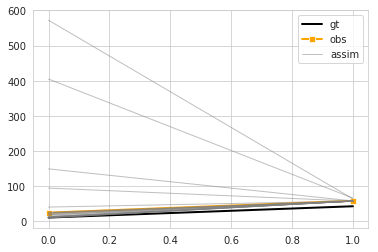

In [16]:
sns.lineplot(range(2), xt[0:2, -1], label="gt", color="k", linewidth=2)
sns.lineplot(range(2), obs[0, 0:2, -1], label="obs", color="orange", marker="s", linewidth=2)
for i in range(eTot):
    sns.lineplot(range(2), [states[0, i, 0, -1], xa[0, i, -1, -1]], color="grey", linewidth=1, alpha=0.5)
sns.lineplot(range(2), [states[0, i, 0, -1], xa[0, i, -1, -1]], color="grey", label="assim", linewidth=1, alpha=0.5)

It works! Let's check other state variables:

In [17]:
a_an = xa[1, :, -1, -1].mean()
b_an = xa[2, :, -1, -1].mean()
a_in = a_init[0, :, 0, -1].mean()
b_in = b_init[0, :, 0, -1].mean()
print("a Truth: {0:.3f} Initial (mean): {1:.3f} Analysis (mean): {2:.3f}".format(at, a_in, a_an))
print("b Truth: {0:.3f} Initial (mean): {1:.3f} Analysis (mean): {2:.3f}".format(bt, b_in, b_an))

a Truth: 2.000 Initial: 49.161 Analysis: 21.676
b Truth: 1.000 Initial: 90.941 Analysis: 9.015


Both improved! Let's iterate more to see what happens.  

Let's update initial conditions for next forwarding.  

In [18]:
def update_state(states_t, xa_t):
    states_t[:,:,-1,:] = xa_t[:,:,-1,:]
    return states_t
states = update_state(states, xa)

In [19]:
for t in range(2, nT):
    states_now = forward_ens(states, eTot, dacore.nReach)
    obs_now = obs[:, t, :]
    obserr_now = obserrs[:, t, :]
    obsvars = [1, 0, 0]  # explained later
    nCPUs = 4
    xa, _ = dacore.letkf_vector(states_now, obs_now, obserr_now, obsvars, nCPUs)
    states = update_state(states_now, xa)